In [1]:
import os
import gensim
from load_vectors import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

unable to import 'smart_open.gcs', disabling that module


In [2]:
print(wv.vectors_vocab.shape)

(2000000, 300)


In [3]:
adjectives = pd.read_csv("data/adjective_synonyms.csv")
adjectives.head()

,hardworking,coward,arrogant,drunken,macho,fiery,chauvinism,lazy,corrupt
0,hardworking,coward,arrogant,drunken,macho,fiery,chauvinism,lazy,corrupt
1,dedicated,wimp,aloof,alcoholic,manly,hot-blooded,patriotism,passive,crooked
2,assiduous,weak,bossy,drinking,machismo,hot-headed,bigotry,procrastinating,fraudulent
3,diligent,mouse,cavalier,alcohol,NaN,hot-tempered,nationalism,idle,rotten
4,assiduous,NaN,cocky,hard-drinker,NaN,passionate,racist,loafing,unethical


In [75]:
nationalities = np.array([['britain', 'british'],
                        ['france', 'french'],
                        ['spain', 'spanish'],
                        ['italy', 'italian'],
                        ['germany','german'],
                        ['poland', 'polish']])
adj_columns = adjectives.columns.values

In [76]:
# distance(u,v) = 1 - cosine_similarity(u,v)
def nationality_distance(wv, nat_arr, adj_arr):
    c,n = nat_arr
    adj_arr = list(adj_arr)
    try:
        n_distances = wv.distances(n, adj_arr)
        c_distances = wv.distances(c, adj_arr)
    except KeyError:
        n_distances = []
        c_distances = []
        for adj in adj_arr:
            if adj in wv:
                n_distances.append(wv.distance(n, adj))
                c_distances.append(wv.distance(c, adj))
        n_distances = np.array(n_distances, dtype=float)
        c_distances = np.array(c_distances, dtype=float)
    distances = (n_distances + c_distances) / 2
    return n, adj_arr[0], adj_arr, distances

In [77]:
results = []
for nat_arr in nationalities:
    for adj in adj_columns:
        adj_arr = adjectives[adj].dropna().tolist()
        results.append(nationality_distance(wv, nat_arr, adj_arr))

In [78]:
results_df = pd.DataFrame(data=results, columns=['nationality', 'stereotype', 'adjectives', 'distances'])

results_df_1 = results_df.distances.apply(pd.Series)\
                    .merge(results_df.drop("adjectives",axis=1), right_index=True, left_index=True)\
                    .drop('distances', axis=1)\
                    .melt(id_vars = ['nationality','stereotype'], value_name="distance")\
                    .drop("variable", axis=1).dropna(axis=0)\
                    .sort_values(['nationality', 'stereotype']).reset_index(drop=True)

results_df_2 = results_df.adjectives.apply(pd.Series)\
                    .merge(results_df.drop("distances",axis=1), right_index=True, left_index=True)\
                    .drop('adjectives', axis=1)\
                    .melt(id_vars = ['nationality','stereotype'], value_name="adjective")\
                    .drop("variable", axis=1).dropna(axis=0)\
                    .sort_values(['nationality', 'stereotype']).reset_index(drop=True)\
                    .drop(['nationality', 'stereotype'], axis=1)

results_df = results_df_1.merge(results_df_2, right_index=True, left_index=True)

In [79]:
results_df.head()

,nationality,stereotype,distance,adjective
0,british,arrogant,0.852927,arrogant
1,british,arrogant,0.881864,aloof
2,british,arrogant,0.868135,bossy
3,british,arrogant,0.815800,cavalier
4,british,arrogant,0.846509,cocky


In [80]:
results_df['weights'] = results_df.apply(lambda x: wv.similarity(x.stereotype, x.adjective), axis=1)
for nat in nationalities[:,1]:
    for st in adj_columns:
        weight_norm = np.sum(results_df.loc[(results_df.nationality == nat)&(results_df.stereotype == st),
                                           'weights'])
        results_df.loc[(results_df.nationality == nat)&(results_df.stereotype == st), 'weights'] /= weight_norm
        
results_df['weighted_distance'] = results_df['distance'] * results_df['weights']

In [81]:
results_df.head()

,nationality,stereotype,distance,adjective,weights,weighted_distance
0,british,arrogant,0.852927,arrogant,0.126929,0.108261
1,british,arrogant,0.881864,aloof,0.071967,0.063465
2,british,arrogant,0.868135,bossy,0.076535,0.066443
3,british,arrogant,0.815800,cavalier,0.059765,0.048756
4,british,arrogant,0.846509,cocky,0.099898,0.084564


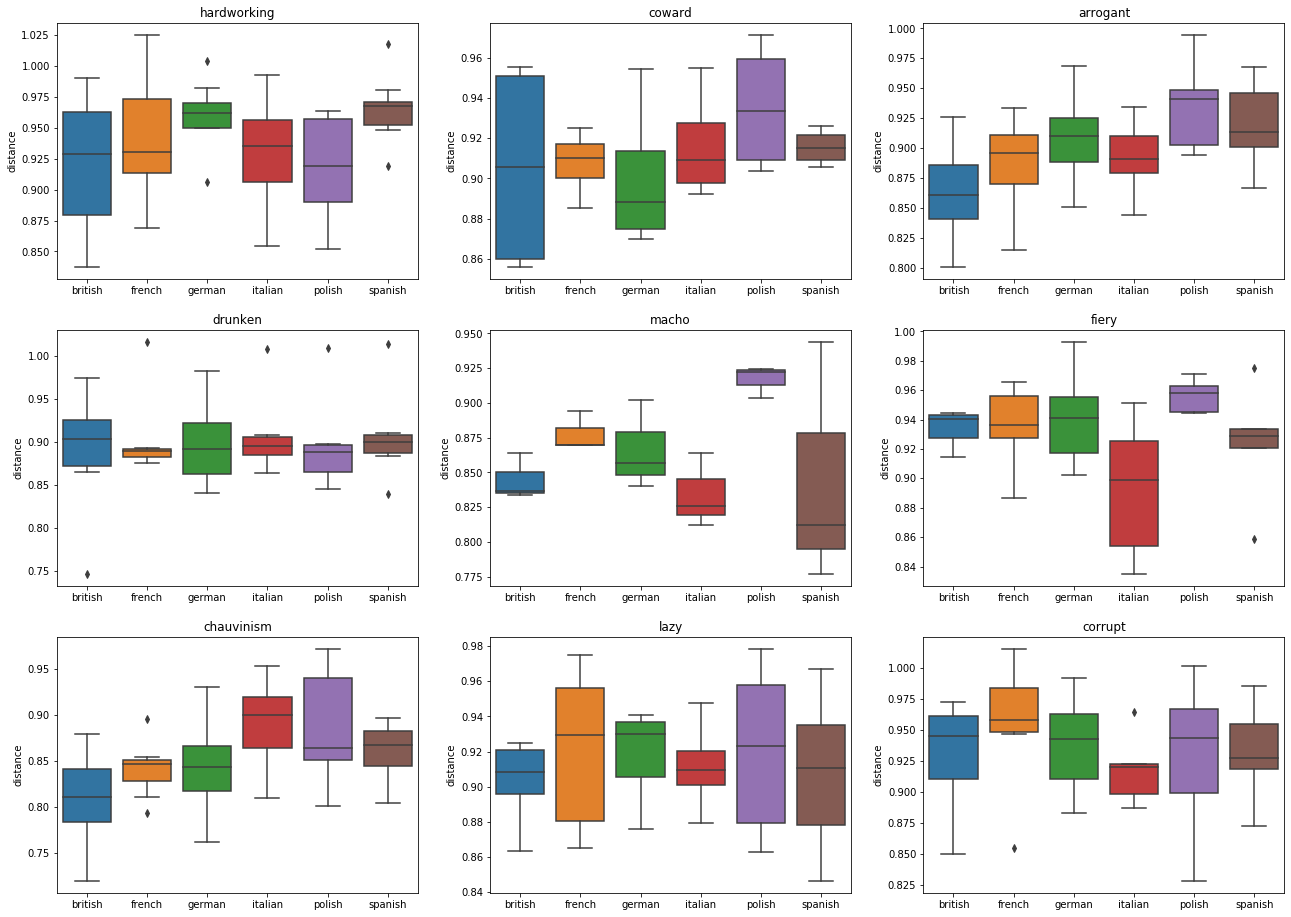

In [82]:
f, axes = plt.subplots(nrows=3, ncols=3, figsize=(22,16))
axes = axes.flatten()
for i, adj in enumerate(adj_columns):
    sub_df = results_df.loc[results_df.stereotype==adj]
    sns.boxplot(x="nationality", y="distance", data=sub_df, ax=axes[i])
    axes[i].set_title(adj)
    axes[i].set_xlabel("")
plt.show()

In [90]:
results_df.loc[(results_df.nationality=='italian')&(results_df.stereotype=='fiery')]

,nationality,stereotype,distance,adjective,weights,weighted_distance
209,italian,fiery,0.951486,fiery,0.322993,0.307323
210,italian,fiery,0.834766,hot-blooded,0.179816,0.150104
211,italian,fiery,0.925538,hot-headed,0.168658,0.156099
212,italian,fiery,0.898721,hot-tempered,0.181523,0.163139
213,italian,fiery,0.854149,passionate,0.147010,0.125569


In [84]:
results_df.loc[(results_df.nationality=='british')&(results_df.stereotype=='drunken')]

,nationality,stereotype,distance,adjective,weights,weighted_distance
29,british,drunken,0.865127,drunken,0.338527,0.292869
30,british,drunken,0.892802,alcoholic,0.174277,0.155595
31,british,drunken,0.913839,drinking,0.150029,0.137102
32,british,drunken,0.928793,alcohol,0.130968,0.121642
33,british,drunken,0.973911,hard-drinker,0.058234,0.056715
34,british,drunken,0.745977,boozer,0.147965,0.110378


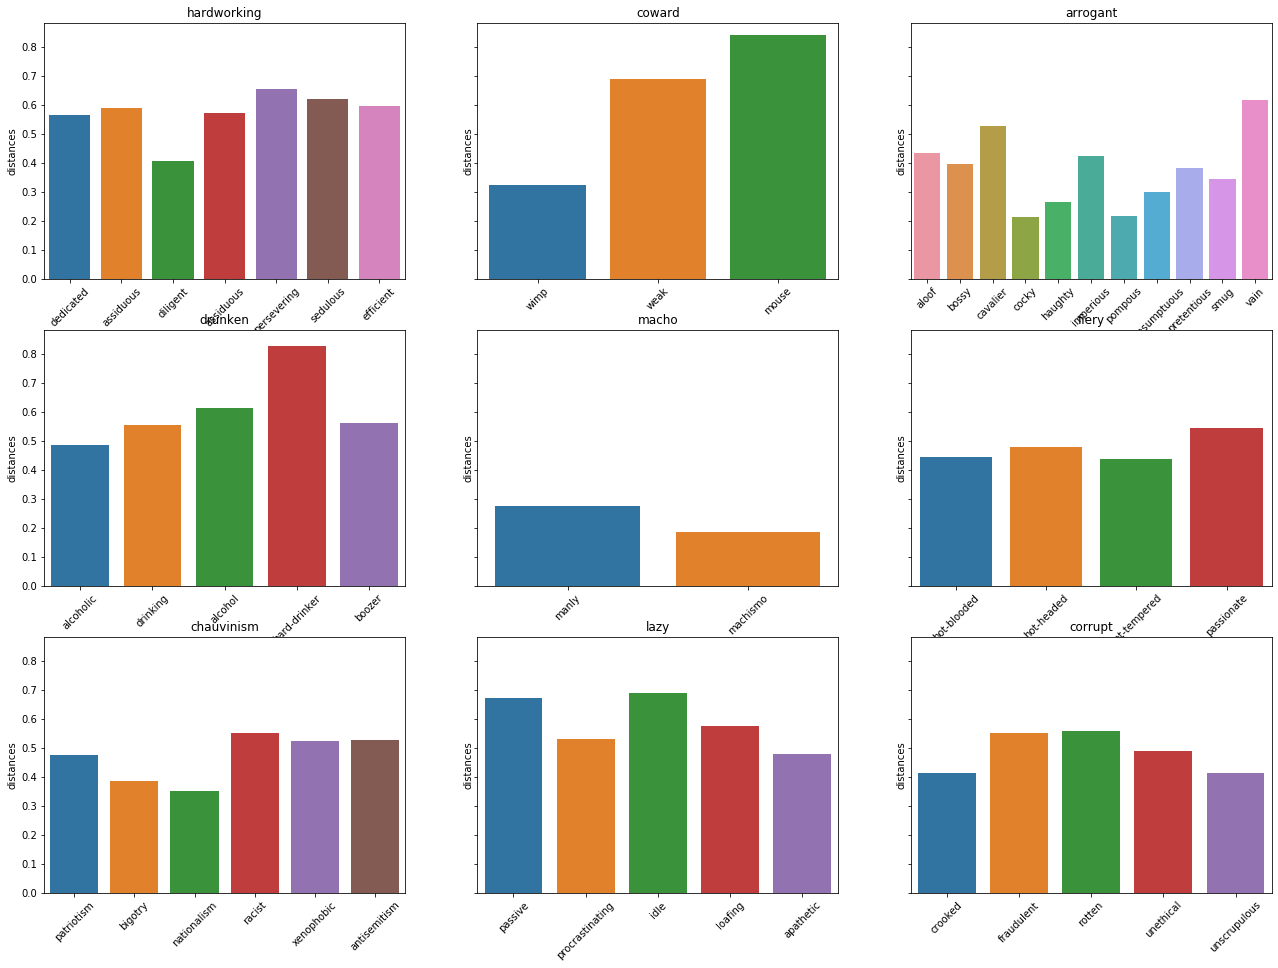

In [85]:
f, axes = plt.subplots(nrows=3, ncols=3, figsize=(22,16), sharey=True)
axes = axes.flatten()
for i, adj in enumerate(adj_columns):

    distance_from_origin_adj = []
    adj_list = adjectives[adj].dropna().values
    for sub_adj in adj_list[1:]:
        distance_from_origin_adj.append(wv.distance(adj,sub_adj))
    sns_df = pd.DataFrame(np.array([adj_list[1:], distance_from_origin_adj]).T,
                          columns=['adjectives', 'distances'])
    sns.barplot(x="adjectives", y ="distances", data=sns_df, ax = axes[i])
    axes[i].set_xticklabels(labels = adj_list[1:], rotation=45)
    axes[i].set_title(adj)
    axes[i].set_xlabel("")
plt.show()

In [86]:
results_df.groupby(['stereotype', "nationality"]).sum()['weighted_distance'].reset_index()

,stereotype,nationality,weighted_distance
0,arrogant,british,0.859780
1,arrogant,french,0.886836
2,arrogant,german,0.907002
3,arrogant,italian,0.890500
4,arrogant,polish,0.935954
5,arrogant,spanish,0.919574
6,chauvinism,british,0.809755
7,chauvinism,french,0.842357
8,chauvinism,german,0.843624
9,chauvinism,italian,0.889628


In [91]:
wv.distances('hot-blooded', ["british", "britain", 'french','france', 'italian', 'italy'])

array([0.84497964, 1.0356117 , 0.8792887 , 0.97524536, 0.74476314,
       0.924768  ], dtype=float32)

In [88]:
wv.distance('britain', 'brexit')

0.560600757598877

In [95]:
with open("data/crime_vocabulary.txt") as f:
    lines = f.readlines()
    crime_words = [w.strip() for w in lines]

In [109]:
len(nationalities)

6

In [132]:
crime_results = []
for nat_arr in nationalities:
    n, _, adj_arr, distances = nationality_distance(wv, nat_arr, crime_words)
    crime_results.append([n, adj_arr, distances])
crime_results = np.array(crime_results)
    
matrix_results = np.zeros((len(crime_words) * len(nationalities), 3), dtype=object)
for k in range(len(nationalities)):
    i = k * len(crime_words)
    matrix_results[i:(i+len(crime_words)),0] = nationalities[k,1]
    matrix_results[i:(i+len(crime_words)),1] = crime_words
    matrix_results[i:(i+len(crime_words)),2] = crime_results[k, 2]
    
crime_df = pd.DataFrame(data=matrix_results, columns=['nationality', 'crime_word', 'distance'])

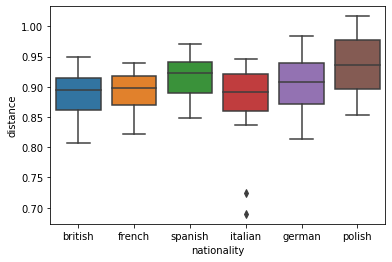

In [134]:
sns.boxplot(x="nationality", y="distance", data=crime_df)

In [138]:
crime_df.loc[(crime_df.nationality=="italian")].sort_values("distance").head()

,nationality,crime_word,distance
122,italian,mafia,0.689668
123,italian,mobster,0.72502
93,italian,crime,0.837234
99,italian,bribery,0.847037
113,italian,perjury,0.850917
